In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import linear_model

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (12,6)
legend_fontsize = 14

pd.set_option('display.max_columns', 30)

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:1003: UserWarning: Duplicate key in file "/root/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))


## Загружаем и визуализируем данные

In [2]:
data = pd.read_csv('owid-covid-data.csv')

In [3]:
data.shape

(17222, 29)

In [4]:
min_date = '2020-03-03'
max_date = data.date.max()
max_date

'2020-05-14'

In [5]:
train_days = 60

In [6]:
ru_data = data[(data.location == 'Russia') & (data.date >= min_date)].reset_index(drop=True).copy()

In [7]:
ru_data['day'] = ru_data.index + 1

In [8]:
print(ru_data.shape)
ru_data.head()

(73, 30)


,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k,day
0,RUS,Russia,2020-03-03,3,1,0,0,0.021,0.007,0.0,0.0,NaN,NaN,NaN,NaN,NaN,145934460.0,8.823,39.6,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,1
1,RUS,Russia,2020-03-04,4,1,0,0,0.027,0.007,0.0,0.0,NaN,NaN,NaN,NaN,NaN,145934460.0,8.823,39.6,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,2
2,RUS,Russia,2020-03-05,4,0,0,0,0.027,0.000,0.0,0.0,46414.0,NaN,0.318,NaN,tests performed,145934460.0,8.823,39.6,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,3
3,RUS,Russia,2020-03-06,4,0,0,0,0.027,0.000,0.0,0.0,51366.0,4952.0,0.352,0.034,tests performed,145934460.0,8.823,39.6,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,4
4,RUS,Russia,2020-03-07,10,6,0,0,0.069,0.041,0.0,0.0,55688.0,4322.0,0.382,0.030,tests performed,145934460.0,8.823,39.6,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,5


In [9]:
def plot_series(x, y, label, fig=None, ax=None):
    fig = fig or plt.figure(figsize=figsize)
    ax = ax or fig.add_subplot(111)
    ax.plot(x, y, linewidth=2, label=label)
    ax.set_xlabel(f'Номер дня, начиная с {min_date}', fontsize=legend_fontsize)
    ax.legend(fontsize=legend_fontsize)
    return fig, ax

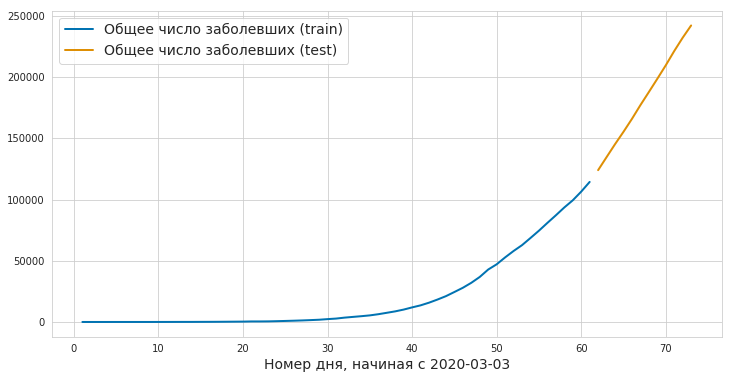

In [10]:
fig, ax = plot_series(ru_data.day.iloc[:train_days+1], ru_data.total_cases.iloc[:train_days+1],
                      'Общее число заболевших (train)')
plot_series(ru_data.day.iloc[train_days+1:], ru_data.total_cases.iloc[train_days+1:],
                      'Общее число заболевших (test)', fig, ax);

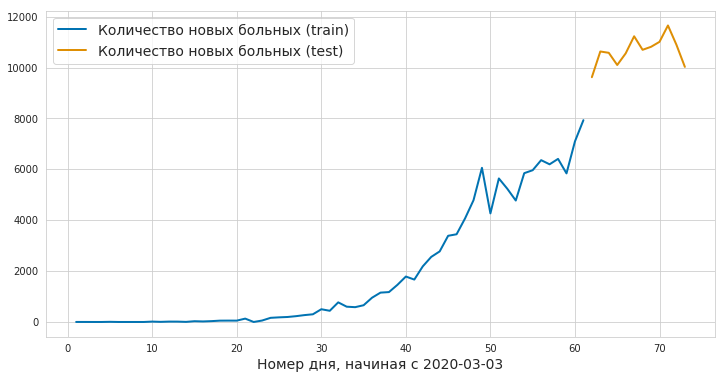

In [11]:
fig, ax = plot_series(ru_data.day.iloc[:train_days+1], ru_data.new_cases.iloc[:train_days+1],
                      'Количество новых больных (train)')
plot_series(ru_data.day.iloc[train_days+1:], ru_data.new_cases.iloc[train_days+1:],
                      'Количество новых больных (test)', fig, ax);

## Модель экспоненциального роста
Будем обучать модель вида $y = exp(w_0 + w_1x)$, где x — номер дня, начиная с 3 марта 2020 года.  
Чтобы применить линейную регрессию, прологарифмируем целевые функции.  
При этом мы неявно делаем предположение, что в логарифмической шкале шум распределён нормально, а значит в исходной - логнормально

In [12]:
log_ru_new_cases = np.log(ru_data.new_cases + 1)
log_ru_total_cases = np.log(ru_data.total_cases)

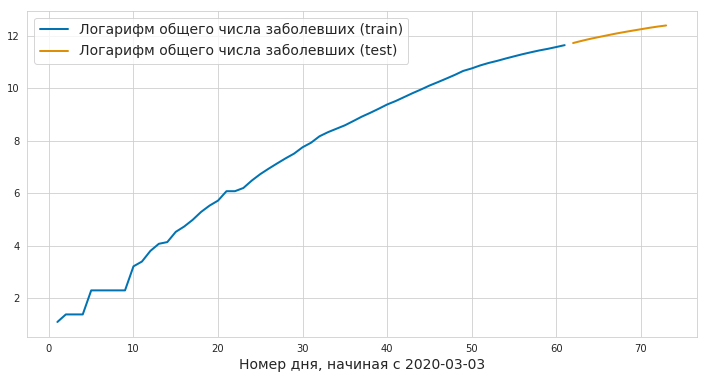

In [13]:
fig, ax = plot_series(ru_data.day.iloc[:train_days+1], log_ru_total_cases.iloc[:train_days+1],
                      'Логарифм общего числа заболевших (train)')
plot_series(ru_data.day.iloc[train_days+1:], log_ru_total_cases.iloc[train_days+1:],
                      'Логарифм общего числа заболевших (test)', fig, ax);

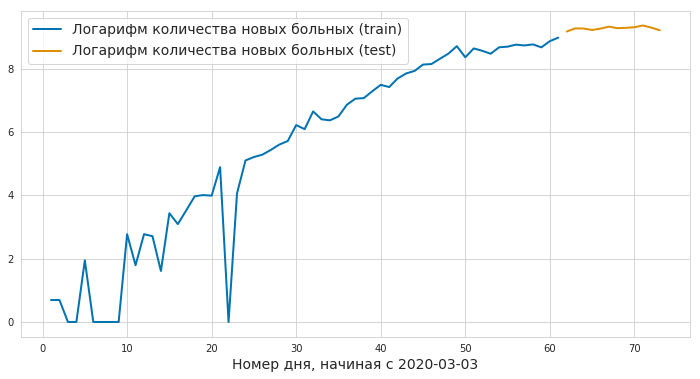

In [14]:
fig, ax = plot_series(ru_data.day.iloc[:train_days+1], log_ru_new_cases.iloc[:train_days+1],
                      'Логарифм количества новых больных (train)')
plot_series(ru_data.day.iloc[train_days+1:], log_ru_new_cases.iloc[train_days+1:],
                      'Логарифм количества новых больных (test)', fig, ax);

### Для начала просто обучим модели методом максимального правдоподобия
То есть получим ML-гипотезу на параметры $w_0$ и $w_1$

In [15]:
def print_model_coefs(model):
    coefs = [model.intercept_] + model.coef_.tolist()
    coef_labels = '[w0,w1]' if len(coefs) == 2 else f'[w0;...;w{len(coefs)-1}]'
    print(f'Коэффициенты модели {coef_labels}: {coefs}')

In [16]:
def eval_ml_model(model, x, y, label_prefix, pred_transform=None):
    pred_transform = pred_transform or (lambda x: x)
    print_model_coefs(model)
    model_pred = pred_transform(model.predict(x.reshape(-1, 1)))
    fig, ax = plot_series(x[:train_days+1], y[:train_days+1], f'{label_prefix} (train)')
    plot_series(x[train_days+1:], y[train_days+1:], f'{label_prefix} (test)', fig, ax)
    plot_series(x, model_pred, f'{label_prefix} (prediction)', fig, ax)

##### Модель для новых больных

In [17]:
log_ru_new_cases_model = linear_model.LinearRegression().fit(ru_data.day.iloc[:train_days+1].values.reshape(-1, 1),
                                                             log_ru_new_cases.iloc[:train_days+1].values)

Коэффициенты модели [w0,w1]: [0.37776455551123256, 0.16184973585410006]


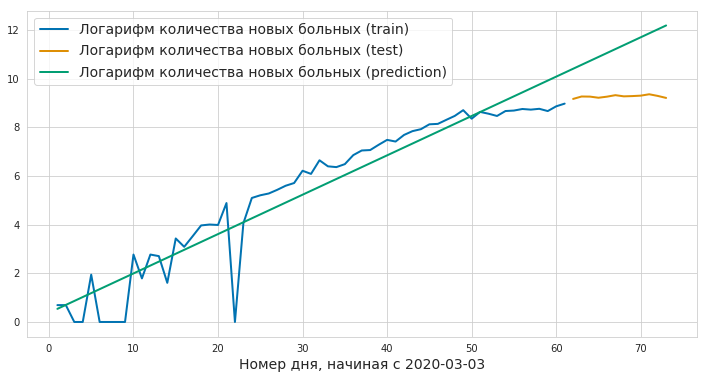

In [18]:
eval_ml_model(log_ru_new_cases_model, ru_data.day.values, log_ru_new_cases.values, 'Логарифм количества новых больных')

Коэффициенты модели [w0,w1]: [0.37776455551123256, 0.16184973585410006]


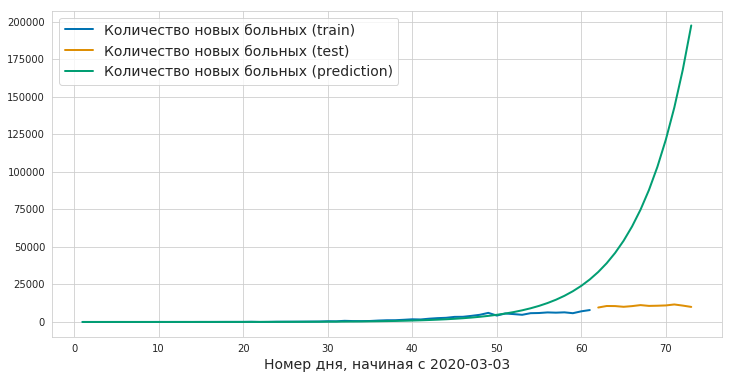

In [19]:
eval_ml_model(log_ru_new_cases_model, ru_data.day.values, ru_data.new_cases.values, 'Количество новых больных',
             pred_transform=lambda x: np.exp(x)-1)

##### Модель для общего числа больных

In [20]:
log_ru_total_cases_model = linear_model.LinearRegression().fit(ru_data.day.iloc[:train_days+1].values.reshape(-1, 1),
                                                             log_ru_total_cases.iloc[:train_days+1].values)

Коэффициенты модели [w0,w1]: [1.6711164676626904, 0.18251035536530677]


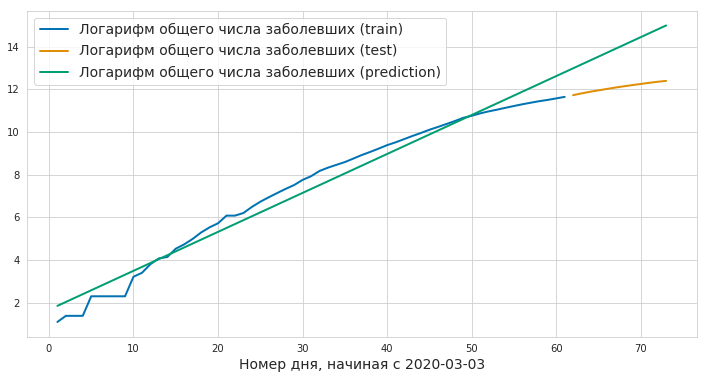

In [21]:
eval_ml_model(log_ru_total_cases_model, ru_data.day.values, log_ru_total_cases.values, 'Логарифм общего числа заболевших')

Коэффициенты модели [w0,w1]: [1.6711164676626904, 0.18251035536530677]


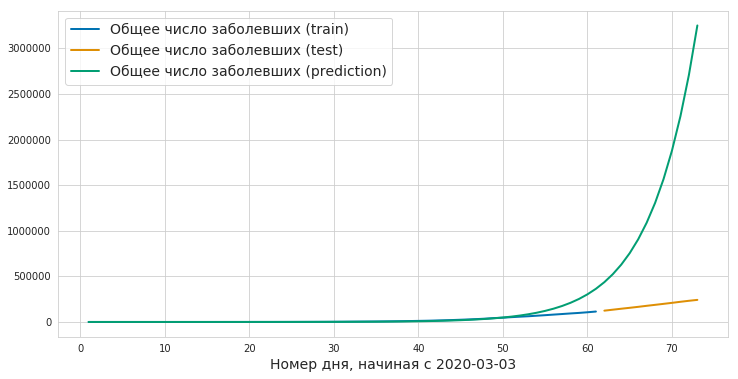

In [22]:
eval_ml_model(log_ru_total_cases_model, ru_data.day.values, ru_data.total_cases.values, 'Общее число заболевших',
             pred_transform=np.exp)

### Теперь получим апостериорное распределение параметров модели
Конечно же для начала нужно задать априорное распределение. В нашем случае удобно взять нормальное распределение.

In [23]:
from scipy.stats import multivariate_normal

def plot_heatmap(func, x_min, x_max, y_min, y_max, title=None, n_points=500):
    x = np.linspace(x_min, x_max, n_points)
    y = np.linspace(y_min, y_max, n_points)
    xs, ys = np.meshgrid(x, y)
    pos = np.empty(xs.shape + (2,))
    pos[:, :, 0] = xs
    pos[:, :, 1] = ys
    z = func(pos)
    plt.pcolormesh(xs, ys, z, cmap=plt.cm.jet)
    if title:
        plt.title(title)
    plt.show()

In [24]:
prior_mu, prior_cov = np.array([0, 0]), np.eye(2) * 3

prior_dist = multivariate_normal(mean=prior_mu, cov=prior_cov)

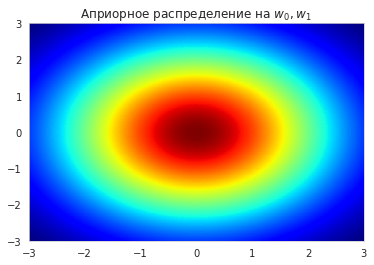

In [25]:
plot_heatmap(prior_dist.pdf, -3, 3, -3, 3, 'Априорное распределение на $w_0, w_1$')

In [26]:
def plot_sample_exponents(dist, x_max=10, y_max=1e5, n=20):
    x_range = np.arange(1, x_max, 0.1)
    for w0, w1 in dist.rvs(n):
        print(f'w0={w0}, w1={w1}')
        plt.plot(x_range, np.exp(w0 + w1 * x_range))
    plt.xlim((0, x_max))
    plt.ylim((0, y_max))
    plt.show()

Примеры параметров и экспонент из априорного распределения
w0=0.8424806119100636, w1=0.4722938778480834
w0=0.12930161567551274, w1=1.8056698933413702
w0=-0.6594101268642106, w1=2.5472557607936333
w0=0.3958491539346678, w1=0.005973056216596144
w0=0.7863869036524053, w1=0.4647250199878695
w0=0.8935684751698421, w1=0.4122700836175729
w0=-0.8559677262208325, w1=2.548931098153597
w0=-0.6443657779683565, w1=1.8562464441071023
w0=1.4634377053478995, w1=-1.4868507981275527
w0=2.188581900563493, w1=2.5523428087723135
w0=0.2916718346581993, w1=0.5441879830259897
w0=0.13454075192323703, w1=-3.959742482721771
w0=-1.431978564596061, w1=0.2598407894746006
w0=1.0659351206802985, w1=-1.7960132531350268
w0=0.4854585781624201, w1=1.527393868286543
w0=-0.01698925586401995, w1=0.603346214042302
w0=-1.0656635602007105, w1=-2.66568976241059
w0=-4.347848659832324, w1=-2.115690215426958
w0=-1.1061951430167505, w1=-0.27794653810472014
w0=-0.4008320097390117, w1=-4.081106864948675


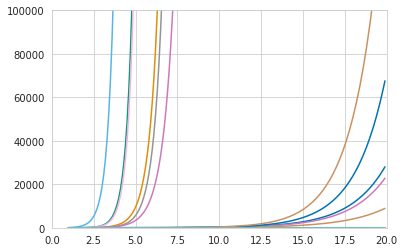

In [27]:
print('Примеры параметров и экспонент из априорного распределения')
plot_sample_exponents(prior_dist, 20)

#### Чтобы найти апостериорное распределение на параметры модели, нужно оценить дисперсию шума в данных
Используем для этого готовую Maximum-Likelihood оценку параметров

In [28]:
def get_variance(model, x, y):
    x_train = x.values[:train_days+1].reshape(-1, 1)
    y_train = y.values[:train_days+1]
    pred = model.predict(x_train)
    return np.var(pred - y_train)

In [29]:
ru_total_cases_variance = get_variance(log_ru_total_cases_model, ru_data.day, log_ru_total_cases)
ru_total_cases_variance

0.28120536741879776

In [30]:
ru_new_cases_variance = get_variance(log_ru_new_cases_model, ru_data.day, log_ru_new_cases)
ru_new_cases_variance

0.8350968830508231

In [31]:
def bayesian_update(prior_mu, prior_cov, x, y, data_variance):
    beta = 1 / data_variance
    x_matrix = np.array([[1, x]])
    y_vector = np.array([y])
    cov_n = np.linalg.inv(np.linalg.inv(prior_cov) + beta * np.matmul(x_matrix.T, x_matrix) )
    mu_n = np.matmul(cov_n,
                     np.matmul(np.linalg.inv(prior_cov), prior_mu.T) + beta * np.matmul(x_matrix.T, y_vector))
    return mu_n, cov_n

In [32]:
def bayesian_updates(prior_mu, prior_cov, xs, ys, data_variance):
    mu, cov = prior_mu, prior_cov
    for x, y in zip(xs, ys):
        mu, cov = bayesian_update(mu, cov, x, y, data_variance)
    return mu, cov

In [33]:
ru_total_cases_mu_posterior, ru_total_cases_cov_posterior = bayesian_updates(prior_mu, prior_cov,
                    ru_data.day.iloc[:train_days+1], log_ru_total_cases.iloc[:train_days+1],
                    ru_total_cases_variance)

In [34]:
ru_total_cases_posterior = multivariate_normal(mean=ru_total_cases_mu_posterior, cov=ru_total_cases_cov_posterior)

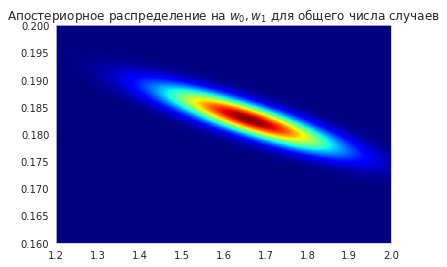

In [55]:
plot_heatmap(ru_total_cases_posterior.pdf, 1.2, 2, 0.16, 0.2,
             'Апостериорное распределение на $w_0, w_1$ для общего числа случаев')

Примеры параметров и экспонент из апостериорного распределения для общего числа случаев
w0=1.6679600393682323, w1=0.18368176025732288
w0=1.6581265562514973, w1=0.17821737057764614
w0=1.6782944844298813, w1=0.1847986220977953
w0=1.3740232871216596, w1=0.18856870187087343
w0=1.5264975499565236, w1=0.18488739579217728
w0=1.6624293451810814, w1=0.18294019060361685
w0=1.5445775582667032, w1=0.1843933459174687
w0=1.5305424419606903, w1=0.1872018905139455
w0=1.667511541626015, w1=0.1805243223838211
w0=1.5460457301194972, w1=0.18598322715874313
w0=1.6323766509972624, w1=0.18163212860574254
w0=1.6844998190397085, w1=0.1852036290044598
w0=1.7723571221273864, w1=0.17952489100323943
w0=1.7992450941021887, w1=0.17663335824806445
w0=1.6060705701545308, w1=0.18407141487716502
w0=1.8175477918867122, w1=0.17822561343545734
w0=1.5160438082325798, w1=0.18656042043158685
w0=1.6277150432733336, w1=0.1831406574698587
w0=1.6330526356272719, w1=0.18597556439308194
w0=1.8135152148476434, w1=0.17807436567036267

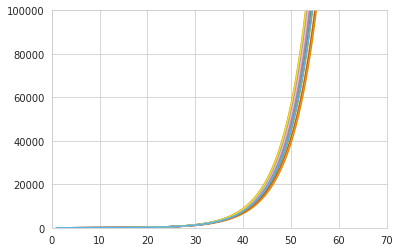

In [36]:
print('Примеры параметров и экспонент из апостериорного распределения для общего числа случаев')
plot_sample_exponents(ru_total_cases_posterior, x_max=70)

In [37]:
ru_new_cases_mu_posterior, ru_new_cases_cov_posterior = bayesian_updates(prior_mu, prior_cov,
                    ru_data.day.iloc[:train_days+1], log_ru_new_cases.iloc[:train_days+1],
                    ru_new_cases_variance)

In [38]:
ru_new_cases_posterior = multivariate_normal(mean=ru_new_cases_mu_posterior, cov=ru_new_cases_cov_posterior)

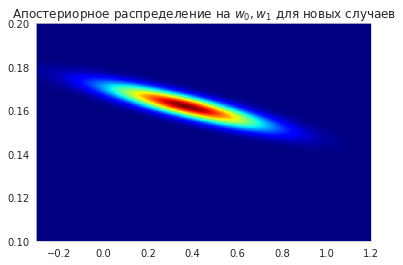

In [54]:
plot_heatmap(ru_new_cases_posterior.pdf, -0.3, 1.2, 0.1, 0.2, 'Апостериорное распределение на $w_0, w_1$ для новых случаев')

Примеры параметров и экспонент из апостериорного распределения для новых случаев
w0=0.5302082919013971, w1=0.15168670626111527
w0=0.48751912397744795, w1=0.15827529536205795
w0=0.0007202723038590708, w1=0.16813360988117793
w0=0.375092813994375, w1=0.1602919657061019
w0=-0.09869498603331367, w1=0.1758861292148382
w0=0.2843520610570658, w1=0.15807530228127642
w0=0.33956880027014186, w1=0.15542971767571334
w0=0.3660151728422298, w1=0.16010480492809873
w0=0.8174937570334979, w1=0.1447623442249082
w0=0.37942373103186855, w1=0.16648997331173063
w0=0.4735601793600794, w1=0.16589821490197731
w0=0.3066098293321914, w1=0.15984680659990436
w0=0.5793285006952823, w1=0.15877216390205973
w0=0.28432221859135315, w1=0.16174224919717084
w0=0.32941451860478344, w1=0.16096660483771363
w0=0.4686930123346965, w1=0.16189053339002785
w0=0.5734886872596612, w1=0.15470740257680185
w0=0.365531136468004, w1=0.15835798562832873
w0=-0.22072726748332838, w1=0.17667585915135742
w0=0.6315112514750947, w1=0.1613791055

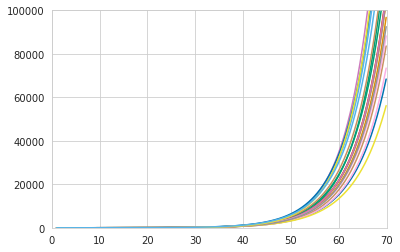

In [40]:
print('Примеры параметров и экспонент из апостериорного распределения для новых случаев')
plot_sample_exponents(ru_new_cases_posterior, x_max=70)

### Найдём предсказательные распределения на общее число случаев в России

In [41]:
def get_day_number(date_str):
    return (pd.to_datetime(date_str) - pd.to_datetime(min_date)).days + 1

#### К первому мая

In [56]:
date = '2020-05-01'
day = get_day_number(date)
day

60

In [57]:
def generate_predictions(distribution, day, n=10000):
    pred_values = []
    for w0, w1 in distribution.rvs(n):
        pred_value = np.exp(w0 + w1 * day)
        pred_values.append(pred_value)
    return pd.Series(pred_values)

In [58]:
def describe_predictions(pred_values, date):
    try:
        real_value = ru_data.loc[ru_data.date == date, 'total_cases'].iloc[0]
    except IndexError:
        real_value = 'N/A'
    print(f'Релаьное число заболевших к {date}: {real_value}')
    print(f'Ожидаемое (среднее по предсказаниям) число заболевших к {date}: {pred_values.mean():.0f}')
    ci_min, ci_max = pred_values.quantile(0.05), pred_values.quantile(0.95)
    print(f'90%-доверительный интервал: ({ci_min:.0f}, {ci_max:.0f})')
    print('Эмпирическое распределение:')
    pred_values.hist(density=True, bins=100);

In [59]:
pred_values = generate_predictions(ru_total_cases_posterior, day)

Релаьное число заболевших к 2020-05-01: 106498
Ожидаемое (среднее по предсказаниям) число заболевших к 2020-05-01: 306922
90%-доверительный интервал: (245803, 377779)
Эмпирическое распределение:


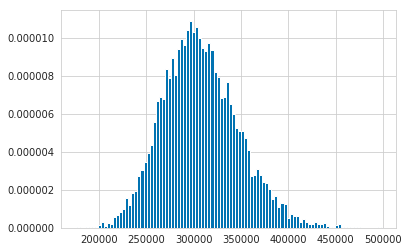

In [60]:
describe_predictions(pred_values, date)

#### К первому июня

In [61]:
date = '2020-06-01'
day = get_day_number(date)
day

91

In [62]:
pred_values = generate_predictions(ru_total_cases_posterior, day)

Релаьное число заболевших к 2020-06-01: N/A
Ожидаемое (среднее по предсказаниям) число заболевших к 2020-06-01: 90372519
90%-доверительный интервал: (59517455, 130603003)
Эмпирическое распределение:


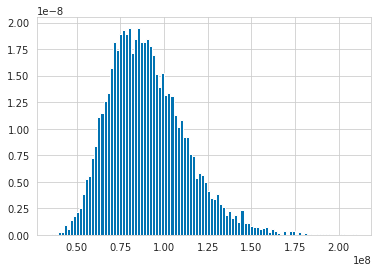

In [63]:
describe_predictions(pred_values, date)

#### К первому сентября

In [64]:
date = '2020-09-01'
day = get_day_number(date)
day

183

In [65]:
pred_values = generate_predictions(ru_total_cases_posterior, day)

Релаьное число заболевших к 2020-09-01: N/A
Ожидаемое (среднее по предсказаниям) число заболевших к 2020-09-01: 2091474729703982
90%-доверительный интервал: (678409361966964, 4559671758477666)
Эмпирическое распределение:


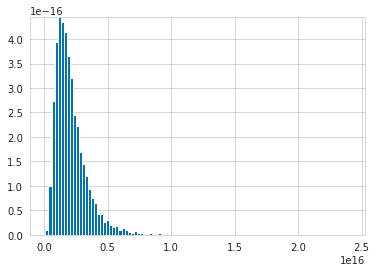

In [66]:
describe_predictions(pred_values, date)

ШОК! К сентябрю в России заболеет 2 квадриллиона людей!